In [1]:
import numpy as np 
import pandas as pd 
import warnings
import os
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation, early_stopping
from sklearn.metrics import classification_report, accuracy_score
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
from functools import partial
import scipy as sp
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import KFold
from joblib import dump

/Users/shendongming/miniconda3/envs/alab_py/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def feature_importance(model, train_data):
    feature_importances = model.booster_.feature_importance(importance_type='gain')
    feature_importance_df = pd.DataFrame({'Feature': train_data.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    return feature_importance_df

def feature_importance_group(model, train_data):
    feature_importances = model.booster_.feature_importance(importance_type='gain')
    feature_names = train_data.columns
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    # Group by the feature name pattern and sum their importances
    # Strip the digits using a regular expression to group
    feature_importance_df['Feature_Group'] = feature_importance_df['Feature'].str.replace(r'\d+', '', regex=True)
    grouped_importance = feature_importance_df.groupby('Feature_Group', as_index=False)['Importance'].sum()
    # Sort by the summed importance
    grouped_importance = grouped_importance.sort_values(by='Importance', ascending=False)
    return grouped_importance

def plot_feature_importance(grouped_importance_df):
    plt.barh(grouped_importance_df['Feature_Group'], grouped_importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Group')
    plt.title('Feature Importance by Group')
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.show()

In [3]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    def coefficients(self):
        return self.coef_['x']

In [4]:
def PreProcessTrain(
    bert_emb, breed_emb, beit_emb, new_cols_ALL,
    bert=True, beit=True, breed=True, txt=True, meta=True, senti=True, newcols=True
):
    name = 'train'
    df = pd.read_csv(f'petfinder-adoption-prediction/{name}/{name}.csv')
    txt_emb = pd.read_csv(f'petfinder-adoption-prediction/{name}/txt_emb.csv').drop(columns=['Description', 'PhotoAmt'])
    metadata_gr = pd.read_csv(f'petfinder-adoption-prediction/{name}/metadata_gr.csv')
    sentiment_gr = pd.read_csv(f'petfinder-adoption-prediction/{name}/sentiment_gr.csv')
    
    if beit:
        beit_emb = pd.read_csv(f'petfinder-adoption-prediction/{name}/beit_emb.csv')
        beit_emb = beit_emb.drop(columns=['Description', 'PhotoAmt'])
    df = pd.merge(df, beit_emb, on=['PetID'], how='left')
    
    if bert: df = pd.merge(df, bert_emb, on=['PetID'], how='left')
    if breed: 
        df = pd.merge(df, breed_emb, left_on=['Breed1'], right_on=['BreedID'], how='left')
        df = df.drop(columns=['BreedID'])    
    if txt: df = pd.merge(df, txt_emb, on=['PetID'], how='left')
    if meta: df = pd.merge(df, metadata_gr, on=['PetID'], how='left')
    if senti: df = pd.merge(df, sentiment_gr, on=['PetID'], how='left')
    if newcols: df = pd.merge(df, new_cols_ALL, on=['PetID'], how='left')
    
    X = df.drop(columns=['AdoptionSpeed', 'Name', 'Description', 'PetID', 'RescuerID'])  # Features
    Y = df['AdoptionSpeed']
    
    non_numeric_columns = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3']
    for col in non_numeric_columns: X[col] = X[col].astype('category')
    
    return X, Y

def PreProcessTest(
    bert_emb, breed_emb, beit_emb, new_cols_ALL,
    bert=True, beit=True, breed=True, txt=True, meta=True, senti=True, newcols=True
):
    name = 'test'
    df = pd.read_csv(f'petfinder-adoption-prediction/{name}/{name}.csv')
    txt_emb = pd.read_csv(f'petfinder-adoption-prediction/{name}/txt_emb.csv').drop(columns=['Description', 'PhotoAmt'])
    metadata_gr = pd.read_csv(f'petfinder-adoption-prediction/{name}/metadata_gr.csv')
    sentiment_gr = pd.read_csv(f'petfinder-adoption-prediction/{name}/sentiment_gr.csv')
    
    if beit:
        beit_emb = pd.read_csv(f'petfinder-adoption-prediction/{name}/beit_emb.csv')
        beit_emb = beit_emb.drop(columns=['Description', 'PhotoAmt'])
    df = pd.merge(df, beit_emb, on=['PetID'], how='left')
    
    if bert: df = pd.merge(df, bert_emb, on=['PetID'], how='left')
    if breed: 
        df = pd.merge(df, breed_emb, left_on=['Breed1'], right_on=['BreedID'], how='left')
        df = df.drop(columns=['BreedID'])
    if txt: df = pd.merge(df, txt_emb, on=['PetID'], how='left')
    if meta: df = pd.merge(df, metadata_gr, on=['PetID'], how='left')
    if senti: df = pd.merge(df, sentiment_gr, on=['PetID'], how='left')
    if newcols: df = pd.merge(df, new_cols_ALL, on=['PetID'], how='left')
    
    X = df.drop(columns=['Name', 'Description', 'PetID', 'RescuerID'])
    
    non_numeric_columns = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3']
    for col in non_numeric_columns: X[col] = X[col].astype('category')
    
    return X

In [22]:
categorical_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3']

def TrainLGBMReg(params, X_train, y_train):
    categorical_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3']
    X_train[categorical_features] = X_train[categorical_features].astype('category')
    params['metric'] = 'rmse'
    params['subsample'] = None
    params['subsample_freq'] = None
    model = LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        categorical_feature=categorical_features
    )
    preds = model.predict(X_train)
    optR = OptimizedRounder()
    optR.fit(preds, y_train.values)
    coefficients = optR.coefficients()
    pred_y = optR.predict(preds, coefficients)
    print(cohen_kappa_score(y_train, pred_y, weights='quadratic'))
    return model, optR, coefficients

def TestResultDF_LGBMReg(model, optR, coef, X_test, name):
    preds = model.predict(X_test) 
    pred_y = optR.predict(preds, coef)
    test_result = pd.DataFrame({'PetID': test_data['PetID'], 'AdoptionSpeed': pred_y})
    print(test_result)
    test_result.to_csv(name, index=False)

In [19]:
def TRAINMODEL(
    bert=True, beit=True, breed=True, txt=True, meta=True, senti=True, newcols=True,
    pca_bert=200, pca_breed=200, pca_beit=500,
    params=None,
    save_address=None,
):
    if not params or not save_address: return 
    
    # read files 
    bert_pca200_ALL = pd.read_csv('petfinder-adoption-prediction/train/bert_pca200_ALL.csv') # 100 enough
    breed_pca200_ALL = pd.read_csv('petfinder-adoption-prediction/train/breed_pca200_ALL.csv') # 100 enough
    beit_pca768_ALL = pd.read_csv('petfinder-adoption-prediction/train/beit_pca768_ALL.csv') # 500 enough?
    bert_emb = bert_pca200_ALL[['PetID'] + [f'bert_pc_{i}' for i in range(1, pca_bert + 1)]] # PetID
    breed_emb = breed_pca200_ALL[['BreedID'] + [f'breed_pc_{i}' for i in range(1, pca_breed + 1)]] # BreedID
    beit_emb = beit_pca768_ALL[['PetID'] + [f'beit_pc_{i}' for i in range(1, pca_beit + 1)]] # PetID
    new_cols_ALL = pd.read_csv('petfinder-adoption-prediction/train/new_cols_ALL.csv') # PetID
    
    # parse inpput
    test_data = pd.read_csv(f'petfinder-adoption-prediction/test/test.csv')
    X_train, y_train = PreProcessTrain(
        bert_emb, breed_emb, beit_emb, new_cols_ALL,
        bert, beit, breed, txt, meta, senti, newcols
    )
    X_test = PreProcessTest(
        bert_emb, breed_emb, beit_emb, new_cols_ALL,
        bert, beit, breed, txt, meta, senti, newcols
    )
    
    # train model
    cat, optR, coefficients = TrainLGBMReg(params, X_train, y_train)
    
    # evaluate model
    imp = feature_importance_group(cat, X_train)
    plot_feature_importance(imp)
    
    # save result
    TestResultDF_LGBMReg(cat, optR, coefficients, X_test, f'Results/{save_address}.csv')
    
    return cat, optR, coefficients, save_address

In [20]:
def OptunaTune(X_train_in, Y_train_in, initial_params=None, nt=100, nj=4):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
    os.environ['LIGHTGBM_VERBOSE'] = '-1'

    X_train, X_valid, y_train, y_valid = train_test_split(X_train_in, Y_train_in, test_size=0.2, random_state=42, stratify=Y_train_in)

    def objective(trial):
        if initial_params and trial.number == 0:
            param = initial_params
            print(f"using initial param for trial {trial.number}")
        else:            
            param = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
                'metric': 'rmse',
                'subsample': None, 
                'subsample_freq': None,
            }

        model = LGBMRegressor(**param)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            callbacks=[early_stopping(100, verbose=False), log_evaluation(5000)],
            categorical_feature=categorical_features
        )
        preds = model.predict(X_valid)
        
        optR = OptimizedRounder()
        optR.fit(preds, y_valid.values)
        coefficients = optR.coefficients()
        pred_valid = optR.predict(preds, coefficients)
        
        loss = cohen_kappa_score(y_valid, pred_valid, weights='quadratic')
        print(f'loss: {loss}. params: {param}.')
        return loss

    # Create a study object and optimize the objective function.
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=nt, n_jobs=nj, show_progress_bar=True)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    return study.best_trial.params

In [58]:
bert=True
beit=True 
breed=True
txt=True
meta=False
senti=False
newcols=True
pca_bert=100
pca_breed=100
pca_beit=1

# read files 
bert_pca200_ALL = pd.read_csv('petfinder-adoption-prediction/train/bert_pca200_ALL.csv') # 100 enough
breed_pca200_ALL = pd.read_csv('petfinder-adoption-prediction/train/breed_pca200_ALL.csv') # 100 enough
beit_pca768_ALL = pd.read_csv('petfinder-adoption-prediction/train/beit_pca768_ALL.csv') # 500 enough?
bert_emb = bert_pca200_ALL[['PetID'] + [f'bert_pc_{i}' for i in range(1, pca_bert + 1)]] # PetID
breed_emb = breed_pca200_ALL[['BreedID'] + [f'breed_pc_{i}' for i in range(1, pca_breed + 1)]] # BreedID
beit_emb = beit_pca768_ALL[['PetID'] + [f'beit_pc_{i}' for i in range(1, pca_beit + 1)]] # PetID
new_cols_ALL = pd.read_csv('petfinder-adoption-prediction/train/new_cols_ALL.csv') # PetID

# parse inpput
test_data = pd.read_csv(f'petfinder-adoption-prediction/test/test.csv')
X_train, y_train = PreProcessTrain(
    bert_emb, breed_emb, beit_emb, new_cols_ALL,
    bert, beit, breed, txt, meta, senti, newcols
)
X_test = PreProcessTest(
    bert_emb, breed_emb, beit_emb, new_cols_ALL,
    bert, beit, breed, txt, meta, senti, newcols
)

### 100 100 avg all

In [34]:
params = {'n_estimators': 989, 'learning_rate': 0.02327966760226766, 'num_leaves': 138, 'max_depth': 8, 'min_child_samples': 91, 'colsample_bytree': 0.6346986239271676, 'reg_alpha': 0.12710216774600558, 'reg_lambda': 3.0088293648608545e-06, 'bagging_freq': 3, 'bagging_fraction': 0.8104522573484685, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None}
# params = OptunaTune(X_train, y_train, initial_params=params, nt=200, nj=-1)

0.965269893901877


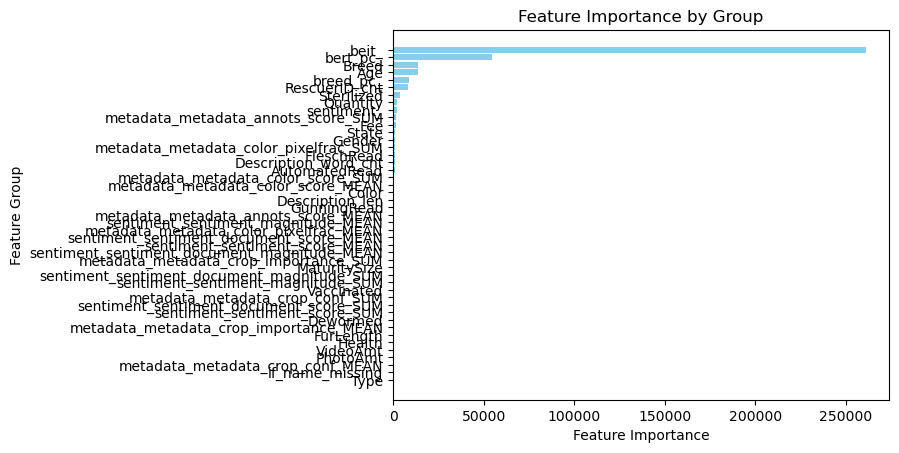

          PetID AdoptionSpeed
0     e2dfc2935             3
1     f153b465f             2
2     3c90f3f54             2
3     e02abc8a3             4
4     09f0df7d1             3
...         ...           ...
3967  ae57f8d52             4
3968  83432904d             3
3969  399013029             3
3970  fd80b8c80             3
3971  493ed84ae             2

[3972 rows x 2 columns]


In [36]:
x = TRAINMODEL(
    bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed, pca_beit,
    # {'n_estimators': 1895, 'learning_rate': 0.0175545806612824, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 83, 'colsample_bytree': 0.7666310551256966, 'reg_alpha': 9.594757816419182e-07, 'reg_lambda': 0.4265614458246769, 'bagging_freq': 1, 'bagging_fraction': 0.8023356108583558, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None}, 
    {'n_estimators': 989, 'learning_rate': 0.02327966760226766, 'num_leaves': 138, 'max_depth': 8, 'min_child_samples': 91, 'colsample_bytree': 0.6346986239271676, 'reg_alpha': 0.12710216774600558, 'reg_lambda': 3.0088293648608545e-06, 'bagging_freq': 3, 'bagging_fraction': 0.8104522573484685, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None},
    save_address="lgbm_100_100_avg_all_2_refit", # 0.965269893901877
) # 100 100 avg all => 

### 100 100 avg noboth

In [31]:
params = {'n_estimators': 1895, 'learning_rate': 0.0175545806612824, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 83, 'colsample_bytree': 0.7666310551256966, 'reg_alpha': 9.594757816419182e-07, 'reg_lambda': 0.4265614458246769, 'bagging_freq': 1, 'bagging_fraction': 0.8023356108583558, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None}
# params = OptunaTune(X_train, y_train, initial_params=params, nt=200, nj=-1)

0.9636476402855897


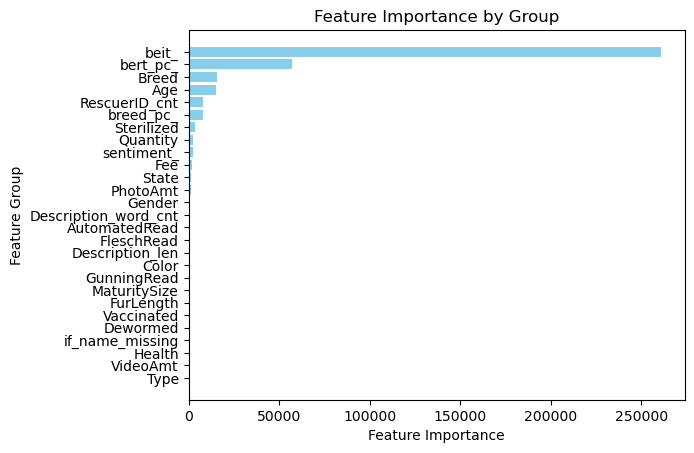

          PetID AdoptionSpeed
0     e2dfc2935             3
1     f153b465f             3
2     3c90f3f54             2
3     e02abc8a3             4
4     09f0df7d1             3
...         ...           ...
3967  ae57f8d52             4
3968  83432904d             3
3969  399013029             3
3970  fd80b8c80             3
3971  493ed84ae             2

[3972 rows x 2 columns]


In [59]:
x = TRAINMODEL(
    bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed, pca_beit,
    # {'n_estimators': 1895, 'learning_rate': 0.0175545806612824, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 83, 'colsample_bytree': 0.7666310551256966, 'reg_alpha': 9.594757816419182e-07, 'reg_lambda': 0.4265614458246769, 'bagging_freq': 1, 'bagging_fraction': 0.8023356108583558, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None}, 
    {'n_estimators': 989, 'learning_rate': 0.02327966760226766, 'num_leaves': 138, 'max_depth': 8, 'min_child_samples': 91, 'colsample_bytree': 0.6346986239271676, 'reg_alpha': 0.12710216774600558, 'reg_lambda': 3.0088293648608545e-06, 'bagging_freq': 3, 'bagging_fraction': 0.8104522573484685, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None},
    save_address="lgbm_100_100_avg_noboth_2_refit", # 0.9636476402855897
) # 100 100 avg noboth => 0.411

In [61]:
x[2] # [0.60696305, 1.8260843 , 2.48510355, 3.17742886]
dump(x[0], 'Models/lgbm_100_100_avg_noboth_411.joblib')

['Models/lgbm_100_100_avg_noboth_411.joblib']

### 200 200 avg all

In [30]:
params = {'n_estimators': 1195, 'learning_rate': 0.018099397094537683, 'num_leaves': 29, 'max_depth': 8, 'min_child_samples': 94, 'colsample_bytree': 0.5853445810823577, 'reg_alpha': 0.007013346297894745, 'reg_lambda': 8.922946174897325e-05, 'bagging_freq': 4, 'bagging_fraction': 0.6697048159548263, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None}
# params = {'n_estimators': 1586, 'learning_rate': 0.015993401577139806, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 87, 'colsample_bytree': 0.883413117799999, 'reg_alpha': 8.375837596919423e-08, 'reg_lambda': 3.1410649447283636, 'bagging_freq': 2, 'bagging_fraction': 0.7738673511278209, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None}
# params = OptunaTune(X_train, y_train, initial_params=params, nt=200, nj=-1)

0.8941263047610747


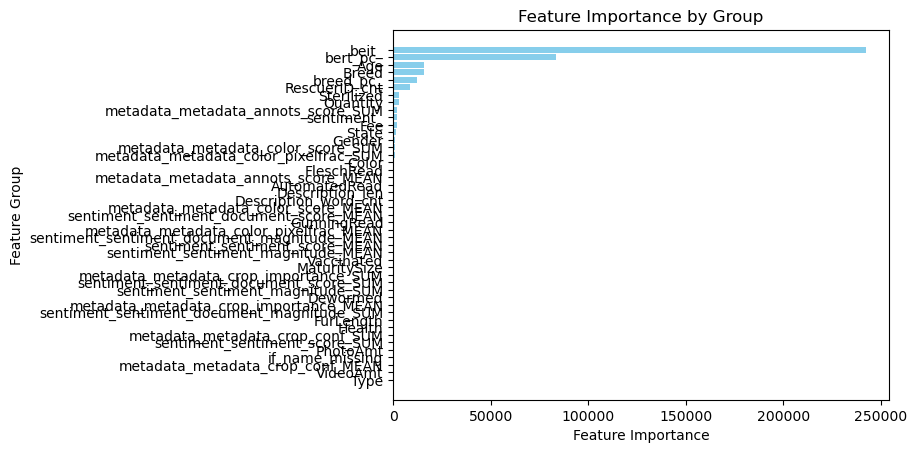

          PetID AdoptionSpeed
0     e2dfc2935             3
1     f153b465f             2
2     3c90f3f54             2
3     e02abc8a3             4
4     09f0df7d1             3
...         ...           ...
3967  ae57f8d52             4
3968  83432904d             3
3969  399013029             3
3970  fd80b8c80             3
3971  493ed84ae             3

[3972 rows x 2 columns]


In [45]:
x = TRAINMODEL(
    bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed, pca_beit,
    {'n_estimators': 1195, 'learning_rate': 0.018099397094537683, 'num_leaves': 29, 'max_depth': 8, 'min_child_samples': 94, 'colsample_bytree': 0.5853445810823577, 'reg_alpha': 0.007013346297894745, 'reg_lambda': 8.922946174897325e-05, 'bagging_freq': 4, 'bagging_fraction': 0.6697048159548263, 'metric': 'rmse', 'subsample': None, 'subsample_freq': None},    
    save_address="lgbm_200_200_avg_all_2_1",
) # 200 200 avg all => TODO NOTE 0.43 => top!!!

In [57]:
x[2] # [0.44232186, 1.9088237 , 2.5220245 , 3.00520755]
dump(x[0], 'Models/lgbm_200_200_avg_all_431.joblib')

['Models/lgbm_200_200_avg_all_431.joblib']

In [47]:
# THIS IS THE BEST => 0.434
r1 = pd.read_csv("Results/lgbm_200_200_avg_all_2.csv")
r2 = pd.read_csv("Results/lgbm_100_100_avg_noboth_3.csv")
# r3 = pd.read_csv("Results/catr_CVreg_2_2_avg_all.csv")
r4 = pd.read_csv("Results/soft.csv")
average_adoptionspeed = (r1['AdoptionSpeed'] + r2['AdoptionSpeed'] + r4['AdoptionSpeed']) / 3
pred_y = x[1].predict(average_adoptionspeed, x[2])
average_df = pd.DataFrame({
    'PetID': r1['PetID'],
    'AdoptionSpeed': pred_y,
})
average_df.to_csv('Results/Xsoft1.csv', index=False)
# TODO NOTE: THIS SOFT VOTING IS OVER 0.

In [48]:
r1 = pd.read_csv("Results/lgbm_200_200_avg_all_2.csv")
r2 = pd.read_csv("Results/lgbm_100_100_avg_noboth_3.csv")
r3 = pd.read_csv("Results/catr_CVreg_2_2_avg_all.csv")
r4 = pd.read_csv("Results/soft.csv")
average_adoptionspeed = (r1['AdoptionSpeed'] + r2['AdoptionSpeed'] + r3['AdoptionSpeed'] + r4['AdoptionSpeed']) / 4
pred_y = x[1].predict(average_adoptionspeed, x[2])
average_df = pd.DataFrame({
    'PetID': r1['PetID'],
    'AdoptionSpeed': pred_y,
})
average_df.to_csv('Results/Xsoft2.csv', index=False)
# TODO NOTE: THIS SOFT VOTING IS OVER 0.

In [49]:
r1 = pd.read_csv("Results/lgbm_200_200_avg_all_2.csv")
# r2 = pd.read_csv("Results/lgbm_100_100_avg_noboth_3.csv")
r3 = pd.read_csv("Results/catr_CVreg_2_2_avg_all.csv")
r4 = pd.read_csv("Results/soft.csv")
average_adoptionspeed = (r1['AdoptionSpeed'] + r3['AdoptionSpeed'] + r4['AdoptionSpeed']) / 3
pred_y = x[1].predict(average_adoptionspeed, x[2])
average_df = pd.DataFrame({
    'PetID': r1['PetID'],
    'AdoptionSpeed': pred_y,
})
average_df.to_csv('Results/Xsoft3.csv', index=False)
# TODO NOTE: THIS SOFT VOTING IS OVER 0.

In [50]:
r1 = pd.read_csv("Results/lgbm_200_200_avg_all_2.csv")
# r2 = pd.read_csv("Results/lgbm_100_100_avg_noboth_3.csv")
# r3 = pd.read_csv("Results/catr_CVreg_2_2_avg_all.csv")
r4 = pd.read_csv("Results/soft.csv")
average_adoptionspeed = (r1['AdoptionSpeed'] + r4['AdoptionSpeed']) / 2
pred_y = x[1].predict(average_adoptionspeed, x[2])
average_df = pd.DataFrame({
    'PetID': r1['PetID'],
    'AdoptionSpeed': pred_y,
})
average_df.to_csv('Results/Xsoft4.csv', index=False)
# TODO NOTE: THIS SOFT VOTING IS OVER 0.

In [51]:
r1 = pd.read_csv("Results/lgbm_200_200_avg_all_2.csv")
r2 = pd.read_csv("Results/lgbm_100_100_avg_noboth_3.csv")
r3 = pd.read_csv("Results/catr_CVreg_2_2_avg_all.csv")
average_adoptionspeed = (r1['AdoptionSpeed'] + r2['AdoptionSpeed'] + r3['AdoptionSpeed']) / 3
pred_y = x[1].predict(average_adoptionspeed, x[2])
average_df = pd.DataFrame({
    'PetID': r1['PetID'],
    'AdoptionSpeed': pred_y,
})
average_df.to_csv('Results/Xsoft0.csv', index=False)
# TODO NOTE: THIS SOFT VOTING IS OVER 0.